In [976]:
from amm import amm
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt
# plt.style.use('paper.mplstyle')

import seaborn as sns
sns.set_theme(style="ticks")

import statsmodels.api as sm
import matplotlib.ticker as mtick
import pickle
import pandas as pd

import cvxpy as cp
import numpy as np
from scipy.linalg import sqrtm
from tqdm import tqdm
import torch


# Helper functions

In [178]:
def plot_hist(returns, zeta, alpha, q):
    
    sns.kdeplot(returns)
    
    p = np.mean(returns >= zeta)
    var = np.quantile(returns, alpha)
    qtl = np.quantile(returns, 1-q)
    cvar = float(np.sum(returns * (returns <= var)) / np.sum(returns <= var)) / (1 - alpha)

    plt.title(f'$\\zeta$ = {zeta}, $\\alpha$={alpha}, q={q}')
    plt.axvline(var, c='y', linestyle='--', label=f'$VaR={var:4.4}$')
    plt.axvline(cvar, c='r', linestyle='--', label=f'$CVaR={cvar:4.4}$')
    plt.axvline(zeta, c='g', linestyle='--', label=f'$P(r\geq{zeta:.4})={p}$')
    plt.axvline(qtl, c='m', linestyle='--', label=f'$P(r\geq{qtl:.4})={q:.4}$')
    plt.legend()

In [179]:
def plot_2d(returns):
    
    N_assets = returns.shape[1]
    
    fig, ax = plt.subplots(nrows=N_assets, ncols=N_assets, figsize=(2 * N_assets + 2, 2 * N_assets), constrained_layout=True)
    fig.suptitle('2D marginals', fontsize=20)

    for i in range(N_assets):
        for j in range(N_assets):
            if i < j:
                ax[i][j].hist2d(returns[:, i], returns[:, j], bins=50, range=[[-0.3, 0.3], [-0.3, 0.3]], cmap='viridis')
            if i > j:
                fig.delaxes(ax[i][j])

        # kde plot
        sns.kdeplot(data=returns[:, i], ax=ax[i][i], fill=True, label='train')

        # gaussian fit
        xs = np.linspace(np.min(returns[:, i]), np.max(returns[:, i]), 101)
        ys = norm.pdf(xs, loc=np.mean(returns[:, i]), scale=np.std(returns[:, i]))
        ax[i][i].plot(xs, ys, c='r', label='gaussian')

# Generate returns

## Option 1: use generator

In [670]:
# original parameters from params.py

# N_pools = 6
# params = {'N_pools': N_pools,
#           'Rx0': 100 * np.ones(N_pools),
#           'Ry0': 1000 * np.ones(N_pools),
#           'phi': 0.03 * np.ones(N_pools),
#           'x_0': 10,
#           'alpha': 0.1,
#           'q': 0.75,
#           'zeta': 0.0,
#           'batch_size': 1_000,
#           'kappa': np.array([0.25, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]),
#           'sigma': np.array([1, 0.3, 0.5, 1.5, 1.75, 2, 2.25]),
#           'p': np.array([0.35, 0.3, 0.34, 0.33, 0.32, 0.31, 0.3]),
#           'T': 60,
#           'seed': 4294967143}

# in this test case return asset0 has lower return, but also lower CVaR
# so without return constraint, one should choose asset0, and as the constraint hits, one should gradually interpolated between 0 and 1

# N_pools = 2
# params = {'N_pools': N_pools,
#           'Rx0': 100 * np.ones(N_pools),
#           'Ry0': 1000 * np.ones(N_pools),
#           'phi': np.array([0.03, 0.1]),
#           'x_0': 10,
#           'alpha': 0.05,
#           'q': 0.75,
#           'zeta': 0.05,
#           'batch_size': 1_000,
#           'kappa': np.array([0.5, 0.5, 0.5]),
#           'sigma': np.array([1., 2., 1.]),
#           'p': np.array([0.3, 0.35, 0.3]),
#           'T': 60,
#           'seed': 4294967143}

N_pools = 3
params = {'N_pools': N_pools,
          'Rx0': 100 * np.ones(N_pools),
          'Ry0': 1000 * np.ones(N_pools),
          'phi': np.array([0.03, 0.1, 0.03]),
          'x_0': 10,
          'alpha': 0.05,
          'q': 0.85,
          'zeta': 0.05,
          'batch_size': 1_000,
          'kappa': np.array([0.5, 1., 0.5, 0.5]),
          'sigma': np.array([0.5, 2., 1., 2.]),
          'p': np.array([0.3, 0.35, 0.3, 0.32]),
          'T': 60,
          'seed': 4294967143}

# put them into global scope, so that we can call e.g. kappa, instead of params['kappa']
locals().update(params)

In [657]:
pools = amm(Rx=Rx0, Ry=Ry0, phi=phi)

xs_0 = np.repeat(1., N_pools)
l = pools.swap_and_mint(xs_0)

np.random.seed(seed)
end_pools, Rx_t, Ry_t, v_t, event_type_t, event_direction_t = pools.simulate(kappa, p, sigma, T=T, batch_size=batch_size)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:06<00:00, 161.79it/s]


In [658]:
x_T = np.array([pool.burn_and_swap(l) for pool in end_pools])
log_ret = np.log(x_T)

## Option 2: use custom Gaussian returns

In [1018]:
# try normal returns instead

# # 2 pools
# N_pools = 2
# np.random.seed(seed)
# log_ret = np.array((0.07, 0.05)) + np.random.standard_normal((1000, N_pools)) * np.array((0.05, 0.03))[None, :]

# # 3 pools
# N_pools = 3
# np.random.seed(seed)
# log_ret = np.array((0.07, 0.05, 0.08)) + np.random.standard_normal((1000, N_pools)) * np.array((0.05, 0.03, 0.07))[None, :]

# 6 pools
N_pools = 6
np.random.seed(seed)
log_ret = np.array((0.07, 0.05, 0.08, 0.07, 0.05, 0.08)) + np.random.standard_normal((1000, N_pools)) * np.array((0.05, 0.03, 0.07, 0.05, 0.03, 0.07))[None, :]

# Visualization of feasible region for N_pools = 3

In [1019]:
N_points = 201

ws0 = np.linspace(0, 1, N_points)
ws1 = np.linspace(0, 1, N_points)
WS0, WS1 = np.meshgrid(ws0, ws1)
WS2 = 1. - WS0 - WS1
R = (WS0[None, :, :] * log_ret[:, 0][:, None, None]) + (WS1[None, :, :] * log_ret[:, 1][:, None, None]) + (WS2[None, :, :] * log_ret[:, 2][:, None, None])
M1 = np.mean(R >= zeta, axis=0)
M2 = np.array([[i + j < 1. for i in ws0] for j in ws1])

Text(0.5, 1.0, '$\\zeta = 0.05$')

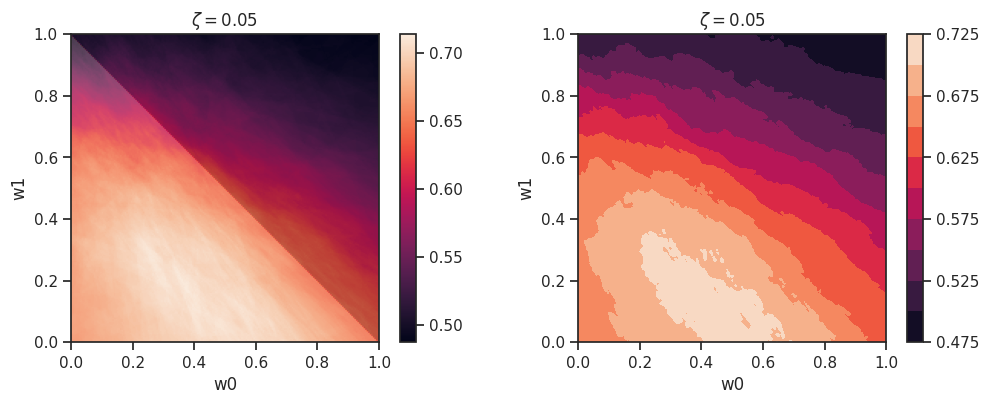

In [1020]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 4))

pos = ax[0].imshow(M1, extent=[0, 1, 0, 1], origin='lower')
plt.colorbar(pos, ax=ax[0])
ax[0].set_xlabel('w0')
ax[0].set_ylabel('w1')

ax[0].imshow(M2, extent=[0, 1, 0, 1], alpha=0.2, origin='lower')
ax[0].set_title(f"$\zeta = {zeta}$")

pos = ax[1].contourf(WS0, WS1, M1, levels=10)
plt.colorbar(pos, ax=ax[1])
ax[1].set_aspect('equal')
ax[1].set_xlabel('w0')
ax[1].set_ylabel('w1')
ax[1].set_title(f"$\zeta = {zeta}$")


# Visualize returns

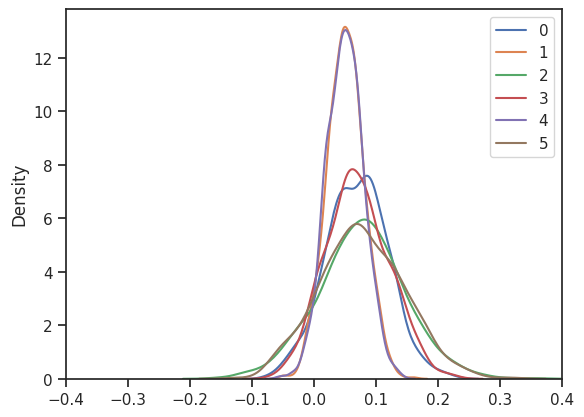

In [1021]:
# 1d marginals on top of each other

for i in range(log_ret.shape[1]):
    sns.kdeplot(log_ret[:, i], label=i)
    
plt.xlim((-0.4, 0.4))
plt.legend()

In [1022]:
mean = log_ret.mean(axis=0)
std = log_ret.std(axis=0)
var = np.quantile(log_ret, alpha, axis=0)
cvar = np.sum(log_ret * (log_ret <= var[None, :]), axis=0) / np.sum(log_ret <= var[None, :], axis=0) / (1 - alpha)
emp_cdf = np.mean(log_ret >= zeta, axis=0)
normal_cdf = np.array([1 - norm.cdf(0.05, loc=np.mean(log_ret[:, i]), scale=np.std(log_ret[:, i])) for i in range(N_pools)])
df = pd.DataFrame([mean, std, cvar, emp_cdf, normal_cdf], index=['Mean', 'Std', 'Marginal CVaR', f"Empirical Marginal CDF @ {zeta}:", f"Normal Marginal CDF @ {zeta}:"])
display(df.style.background_gradient(cmap='coolwarm', axis=1))

print(f"Correlation matrix:")
corr = pd.DataFrame(np.corrcoef(log_ret.T))
display(corr.style.background_gradient(cmap='coolwarm', axis=None))

,0,1,2,3,4,5
Mean,0.069599,0.050769,0.076740,0.069802,0.049930,0.077214
Std,0.049882,0.029724,0.070342,0.051013,0.029508,0.068631
Marginal CVaR,-0.036615,-0.011182,-0.076253,-0.030800,-0.011828,-0.061541
Empirical Marginal CDF @ 0.05:,0.642000,0.507000,0.659000,0.641000,0.500000,0.648000
Normal Marginal CDF @ 0.05:,0.652805,0.510317,0.648081,0.651061,0.499053,0.654140


Correlation matrix:


,0,1,2,3,4,5
0,1.000000,0.020389,0.002264,0.016267,-0.026928,0.026260
1,0.020389,1.000000,-0.021720,-0.019957,0.014835,0.022563
2,0.002264,-0.021720,1.000000,0.056875,0.023386,-0.017738
3,0.016267,-0.019957,0.056875,1.000000,-0.020198,0.022277
4,-0.026928,0.014835,0.023386,-0.020198,1.000000,-0.054625
5,0.026260,0.022563,-0.017738,0.022277,-0.054625,1.000000


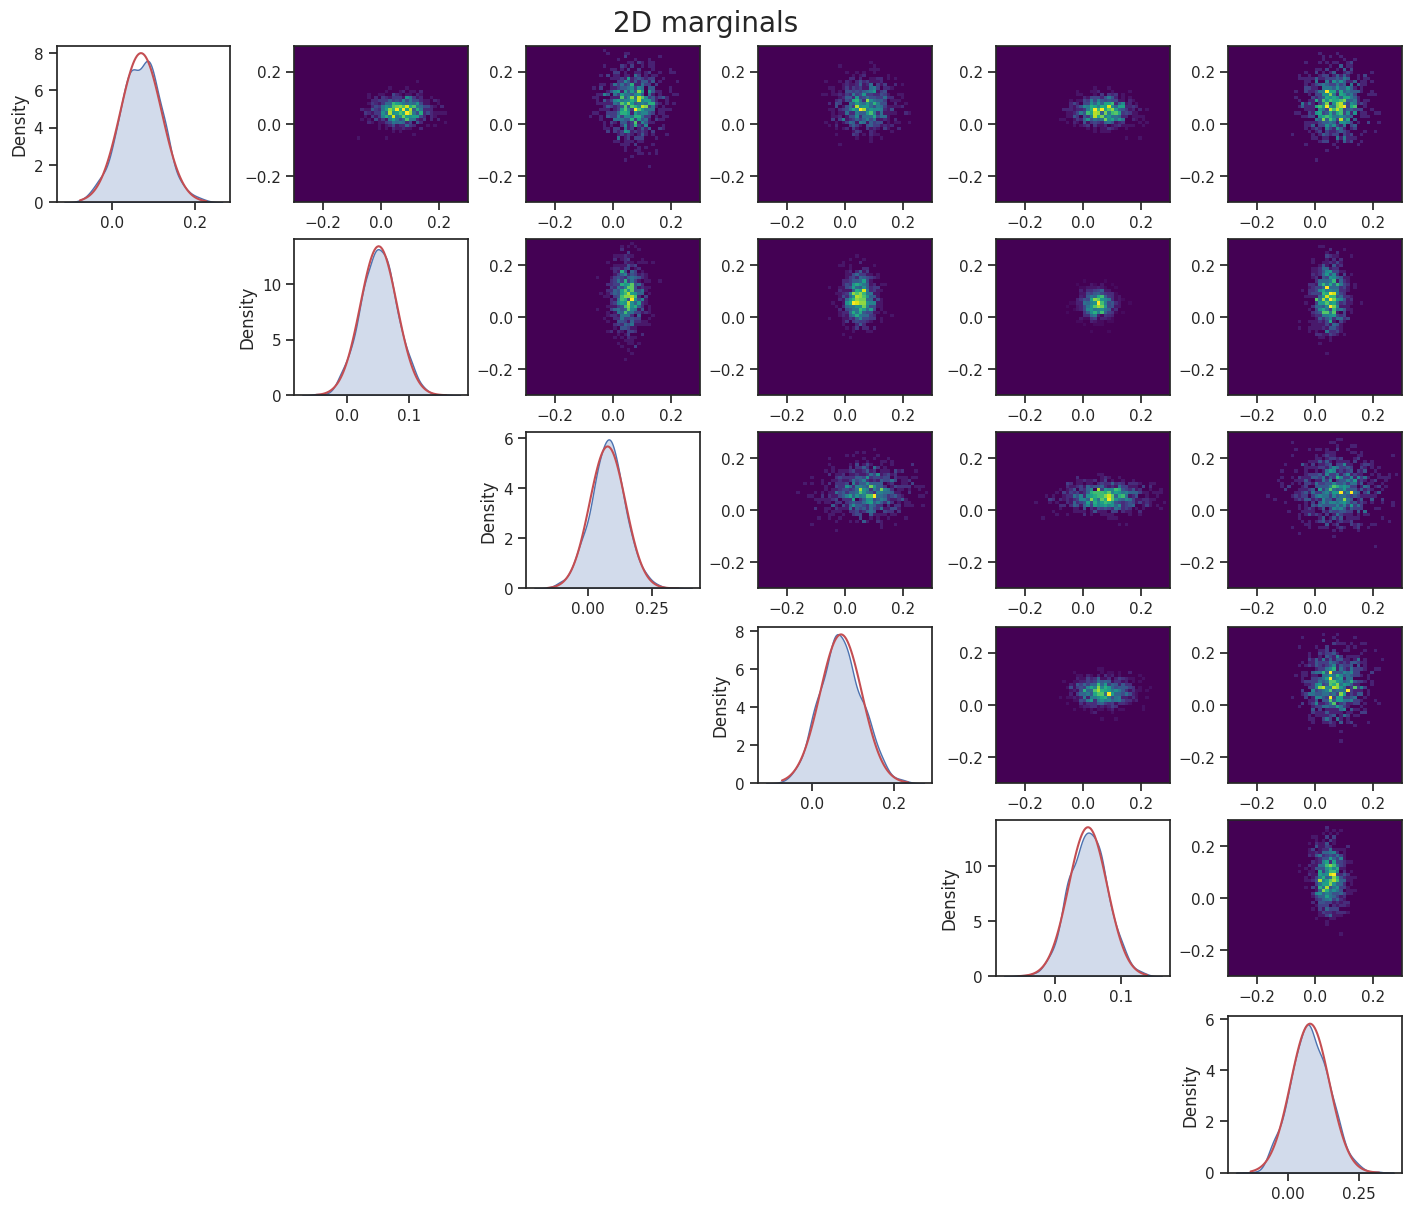

In [1023]:
plot_2d(log_ret)

# Average of quantiles vs. quantiles of averages

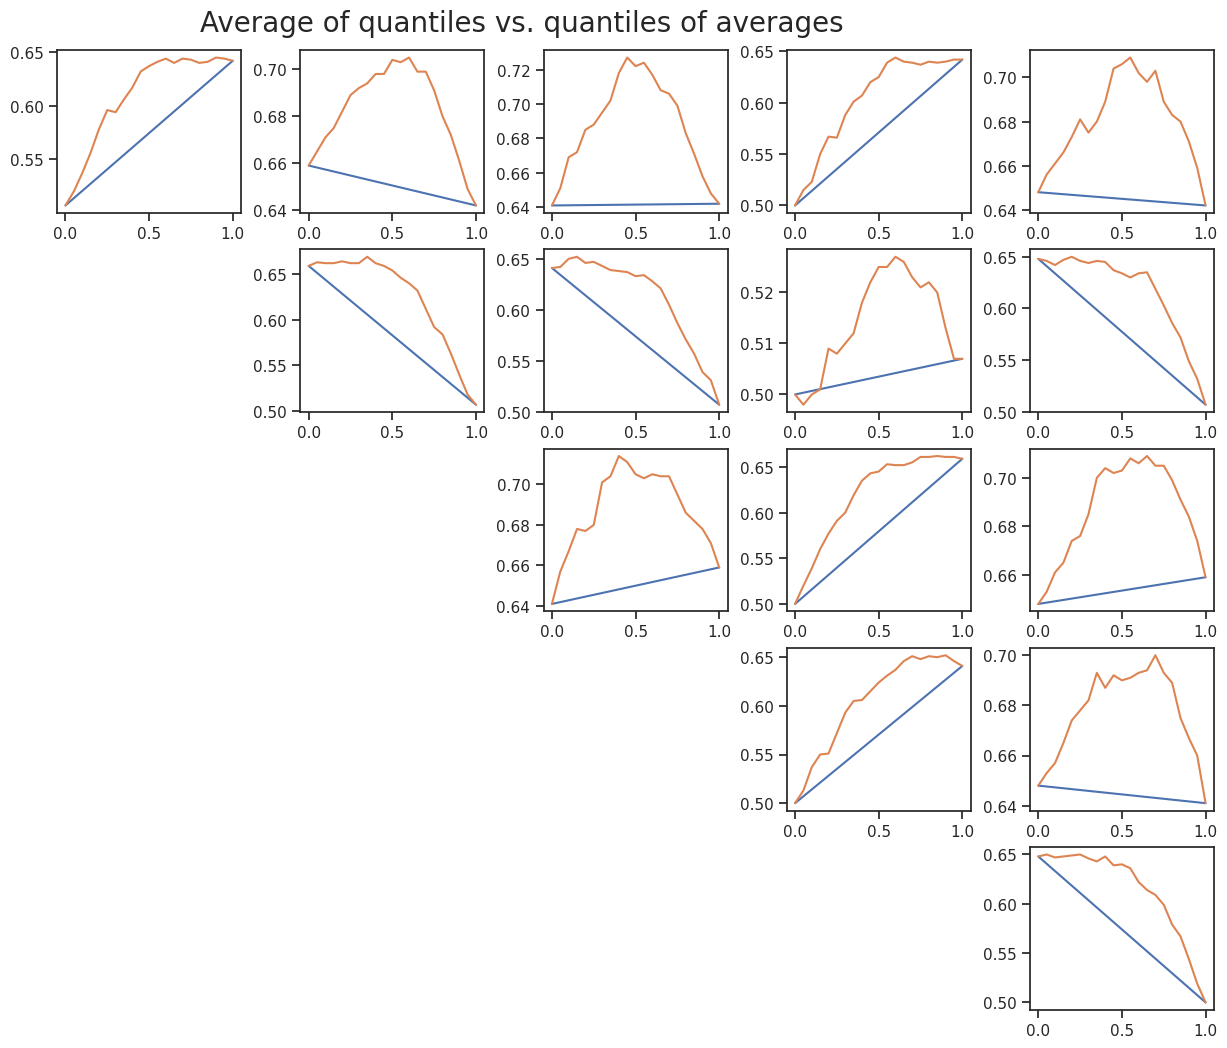

In [1024]:
fig, ax = plt.subplots(nrows=N_pools, ncols=N_pools, figsize=(2 * N_pools + 2, 2 * N_pools), constrained_layout=True)
fig.suptitle('Average of quantiles vs. quantiles of averages', fontsize=20)

for i in range(N_pools):
    for j in range(N_pools):
        if i < j:
            q0, q1 = np.mean(log_ret[:, i] >= zeta), np.mean(log_ret[:, j] >= zeta)

            ws = np.linspace(0, 1, 21)
            ps0 = ws * q0 + (1 - ws) * q1
            ps1 = np.mean(ws[:, None] @ log_ret[:, i][None, :] + ((1 - ws[:, None]) @ log_ret[:, j][None, :]) >= zeta, axis=1)

            ax[i][j].plot(ws, ps0)
            ax[i][j].plot(ws, ps1)
            
        if i >= j:
            fig.delaxes(ax[i][j])


# Optimization with riskfolio

In [1025]:
import riskfolio as rp
import pandas as pd

Portfolio weights:


,0,1,2,3,4,5
weights,0.176639,0.250711,0.076962,0.155843,0.279801,0.060045


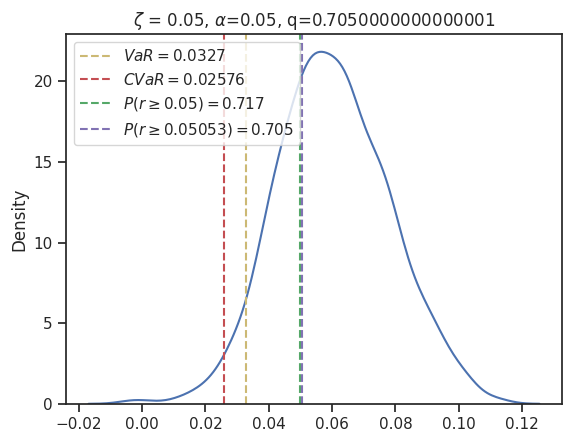

In [1026]:
# Building the portfolio object
port = rp.Portfolio(returns=pd.DataFrame(log_ret))

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'CVaR' # Risk measure used, this time will be variance
obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

weights = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

print("Portfolio weights:")
display(weights.T)

portfolio_returns = log_ret @ weights
portfolio_returns = portfolio_returns.to_numpy().T[0]
plot_hist(portfolio_returns, zeta=zeta, alpha=alpha, q=q)

# Optimization by hand

1. Adjust code from `riskfolio/src/Portfolio.py`, and incorporate our constraints P(ret >= 0.5) >= 0.7
2. Check if this constraint can be accommodated by riskfolio library

## Linear inequality with second-order constraints

- consider $a^T x \leq b$, with $a \sim \mathcal{N}(\bar{a}, \Sigma)$
- then $a^T x-b \sim \mathcal{N}\left(\bar{a}^T x-b, x^T \Sigma x\right)$
- hence
$$
\operatorname{Prob}\left(a^T x \leq b\right)=\Phi\left(\frac{b-\bar{a}^T x}{\sqrt{x^T \Sigma x}}\right)
$$
- and so
$$
\operatorname{Prob}\left(a^T x \leq b\right) \geq \eta \Longleftrightarrow b-\bar{a}^T x \geq \Phi^{-1}(\eta)\left\|\Sigma^{1 / 2} x\right\|_2
$$
a second-order cone constraint for $\eta \geq 0.5$ (i.e., $\Phi^{-1}(\eta) \geq 0$ )

Objective (CVaR): 0.02448
Portfolio weights:


,0,1,2,3,4,5
0,0.176661,0.250724,0.076951,0.15581,0.279807,0.060047


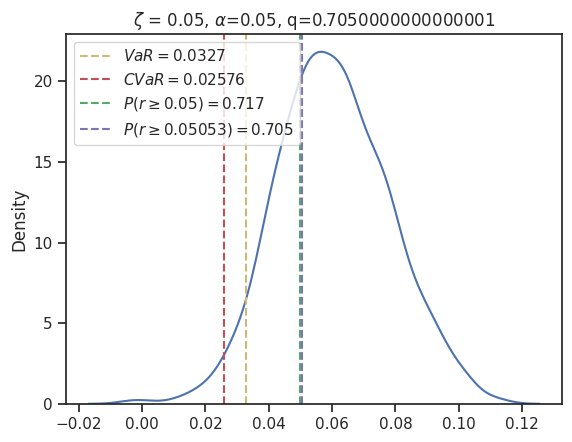

In [1027]:
N_returns, N_assets = log_ret.shape

weights = cp.Variable((N_assets,))
X = log_ret @ weights

Z = cp.Variable((N_returns,))
var = cp.Variable((1,))
cvar = var + 1 / (alpha * N_returns) * cp.sum(Z)

constraints = [cp.sum(weights) == 1., weights <= 1., weights * 1000 >= 0]

# CVaR constraints
constraints += [Z * 1000 >= 0, Z * 1000 >= -X * 1000 - var * 1000]

# # lower bound: average of emp cdf:
# # might not be a valid constraint!
# emp_cdf_005 = np.mean(log_ret >= 0.05, axis=0)
# constraints += [emp_cdf_005 @ weights * 1000 >= q * 1000]

# normal approximation with SOC constraint
mean, cov = log_ret.mean(axis=0), np.cov(log_ret.T)
sqrtcov = sqrtm(cov)
constraints += [cp.SOC((-zeta + mean @ weights) / norm.ppf(q), sqrtcov @ weights)]

# # naive idea for the return constraint:
# constraints += [cp.sum(log_ret @ weights >= zeta) >= q * N_returns]

objective = cp.Minimize(cvar * 1000)

# possible solvers: "ECOS", "SCS", "OSQP", "CVXOPT"
prob = cp.Problem(objective, constraints)
result = prob.solve(solver="SCS")

print(f"Objective (CVaR): {-result/1000:.4}")

portfolio_weights = weights.value
portfolio_returns = log_ret @ portfolio_weights

print("Portfolio weights:")
display(pd.DataFrame(portfolio_weights).T)
plot_hist(portfolio_returns, zeta=zeta, alpha=alpha, q=q)

In [1077]:
N_points = 21
N_additional_constraints = 4
N_metrics = 3

qs = np.linspace(0.61, 0.91, N_points)
results = np.full((N_points, N_additional_constraints, N_metrics), np.nan)

for i, q in tqdm(enumerate(qs)):
    
    N_returns, N_assets = log_ret.shape
    
    weights = cp.Variable((N_assets,))
    X = log_ret @ weights
    
    Z = cp.Variable((N_returns,))
    var = cp.Variable((1,))
    cvar = var + 1 / (alpha * N_returns) * cp.sum(Z)
    
    constraints = [cp.sum(weights) == 1., weights <= 1., weights * 1000 >= 0]
    
    # CVaR constraints
    constraints += [Z * 1000 >= 0, Z * 1000 >= -X * 1000 - var * 1000]

    arr = []

    # unconstrained, for demostration purposes
    arr += [[]]
    
    # lower bound: average of emp cdf:
    # might not be a valid constraint!
    emp_cdf_005 = np.mean(log_ret >= 0.05, axis=0)
    arr += [[emp_cdf_005 @ weights * 1000 >= q * 1000]]
    
    # normal approximation with SOC constraint
    mean, cov = log_ret.mean(axis=0), np.cov(log_ret.T)
    sqrtcov = sqrtm(cov)
    arr += [[cp.SOC((-zeta + mean @ weights) / norm.ppf(q), sqrtcov @ weights)]]

    N_completed = 0

    for j, additional_constraints in enumerate(arr):
        
        try:

            # # naive idea for the return constraint:
            # constraints += [cp.sum(log_ret @ weights >= zeta) >= q * N_returns]
            
            objective = cp.Minimize(cvar * 1000)
            
            # possible solvers: "ECOS", "SCS", "OSQP", "CVXOPT"
            prob = cp.Problem(objective, constraints + additional_constraints)
            result = prob.solve(solver="SCS")
                        
            portfolio_weights = weights.value
            portfolio_returns = log_ret @ portfolio_weights
            
            # print("Portfolio weights:")
            # display(pd.DataFrame(portfolio_weights).T)
            # plot_hist(portfolio_returns, zeta=zeta, alpha=alpha, q=q)
            
            results[i, j, 0] = portfolio_weights[0]
            results[i, j, 1] = -result/1000
            results[i, j, 2] = np.mean(portfolio_returns >= zeta)

            N_completed += 1
                
        except: 
            continue
            
    try:
        weights, cvar, q_out = backprop(q)
        results[i, -1, 0], results[i, -1, 1], results[i, -1, 2] = weights[0], cvar, q_out
    except:
        pass

    # if failed for all constraints apart from unconstrained, break
    if N_completed == 1:
        break

1it [00:02,  2.79s/it]

0.61 [0.18476604 0.21635468 0.07115161 0.15140994 0.30980837 0.06650934] 0.025652971 0.72


2it [00:06,  3.09s/it]

0.625 [0.15900575 0.25631216 0.07346348 0.15292646 0.2972761  0.06101598] 0.025739094 0.712


3it [00:08,  2.91s/it]

0.64 [0.17756513 0.29858962 0.08939953 0.15777728 0.21467732 0.06199115] 0.025556786 0.713


4it [00:11,  2.89s/it]

0.655 [0.15901108 0.23934828 0.0904266  0.1855947  0.24951565 0.07610368] 0.025521992 0.727


5it [00:14,  3.01s/it]

0.67 [0.19345707 0.2442701  0.07352365 0.15633996 0.26990584 0.06250344] 0.025714124 0.717


6it [00:17,  2.82s/it]

0.685 [0.15253529 0.26410115 0.08643039 0.16996638 0.26087323 0.06609358] 0.02572367 0.714


7it [00:19,  2.71s/it]

0.7 [0.16940366 0.20648094 0.07740632 0.14843844 0.32836244 0.06990826] 0.025581475 0.726


8it [00:22,  2.59s/it]

0.715 [0.18714523 0.28779078 0.088094   0.15742616 0.21778664 0.06175723] 0.025548428 0.718


9it [00:24,  2.45s/it]

0.73 [0.20581888 0.24668846 0.09144241 0.15896372 0.2273114  0.06977513] 0.025448378 0.735


10it [00:26,  2.36s/it]

0.745 [0.18363567 0.21691282 0.09784379 0.16518614 0.24654418 0.08987733] 0.025277218 0.751


11it [00:28,  2.27s/it]

0.76 [0.1845502  0.19679424 0.10331367 0.19902968 0.21022215 0.10609011] 0.024592955 0.763


12it [00:30,  2.27s/it]

0.775 [0.1866082  0.20485237 0.11856676 0.24066043 0.12529936 0.12401299] 0.022996694 0.775


12it [00:32,  2.74s/it]

0.79 [0.25765467 0.12501167 0.10752838 0.21530844 0.08238713 0.2121097 ] 0.0191132 0.788


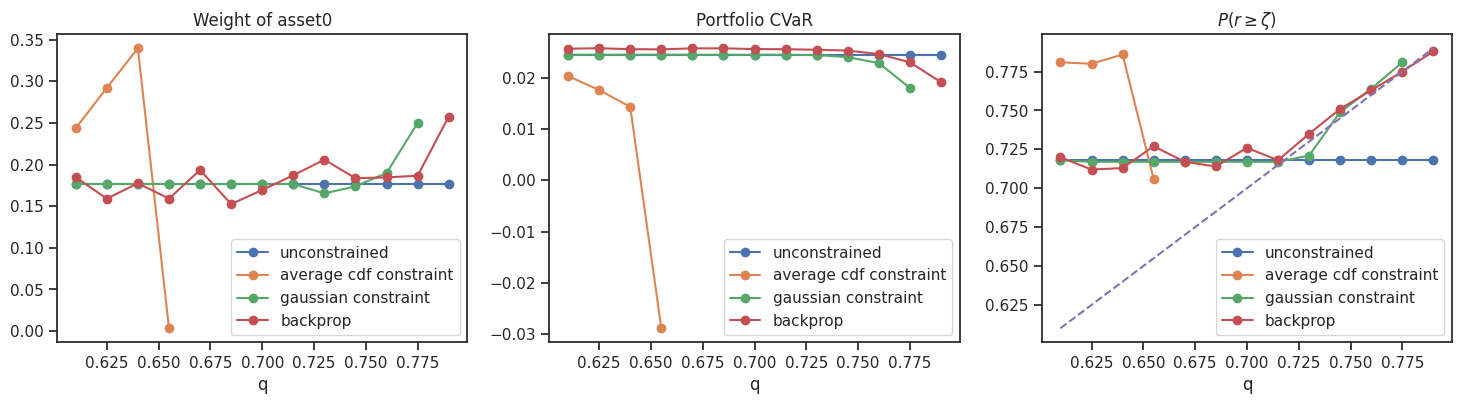

In [1078]:
fig, ax = plt.subplots(ncols=3, figsize=(18, 4))

ax[0].set_title('Weight of asset0')
ax[0].plot(qs, results[:, 0, 0], marker='o', label='unconstrained')
ax[0].plot(qs, results[:, 1, 0], marker='o', label='average cdf constraint')
ax[0].plot(qs, results[:, 2, 0], marker='o', label='gaussian constraint')
ax[0].plot(qs, results[:, 3, 0], marker='o', label='backprop')
ax[0].set_xlabel('q')
ax[0].legend()

ax[1].set_title('Portfolio CVaR')
ax[1].plot(qs, results[:, 0, 1], marker='o', label='unconstrained')
ax[1].plot(qs, results[:, 1, 1], marker='o', label='average cdf constraint')
ax[1].plot(qs, results[:, 2, 1], marker='o', label='gaussian constraint')
ax[1].plot(qs, results[:, 3, 1], marker='o', label='backprop')
ax[1].set_xlabel('q')
ax[1].legend()

ax[2].set_title('$P(r \geq \zeta)$')
ax[2].plot(qs, results[:, 0, 2], marker='o', label='unconstrained')
ax[2].plot(qs, results[:, 1, 2], marker='o', label='average cdf constraint')
ax[2].plot(qs, results[:, 2, 2], marker='o', label='gaussian constraint')
ax[2].plot(qs, results[:, 3, 2], marker='o', label='backprop')
i0, i1 = np.argmax(~np.isnan(results).all(axis=(1, 2))), np.argmin(~np.isnan(results).all(axis=(1, 2)))
ax[2].plot(qs[i0:i1], qs[i0:i1], ls='--')
ax[2].set_xlabel('q')
ax[2].legend()

# Optimization with pytorch

In [1076]:
def backprop(q):

    dtype = torch.float
    device = torch.device("cpu")
    
    x = torch.tensor(log_ret, device=device, dtype=dtype)
    w = torch.rand((N_pools,), device=device, dtype=dtype, requires_grad=True)
    
    learning_rate = 1e-2
    losses = []
    weights = []
    
    relu = torch.nn.ReLU()
    
    for t in range(2000):
        
        returns = x @ w / torch.sum(w)
    
        var = torch.quantile(returns, alpha, axis=0)
        cvar = torch.sum(returns * (returns <= var), axis=0) / torch.sum(returns <= var, axis=0) / (1 - alpha)
    
        # chance constraint
        # loss1 = (torch.mean((returns >= zeta).float()) - q) ** 2
        loss1 = torch.relu(q - torch.mean(torch.sigmoid(1000 * (returns - zeta)))) ** 2
    
        # ensure that weights not negative
        loss2 = torch.mean(relu(-w))
    
        # ensure that weights sum to one
        loss3 = torch.square(torch.sum(w) - 1.)
            
        # CVaR constraints
        loss4 = -cvar
    
        # total loss
        loss = 1e2*loss1 + loss2 + loss3 + loss4
    
        losses += [[loss.detach().cpu().numpy(), loss1.detach().cpu().numpy(), loss2.detach().cpu().numpy(), loss3.detach().cpu().numpy(), loss4.detach().cpu().numpy()]]
        weights += [w.detach().cpu().numpy().copy()]
    
        loss.backward()
        with torch.no_grad():
            w -= learning_rate * w.grad
            w.grad = None
    
    losses = np.array(losses)
    weights = np.array(weights)
    
    w = w / torch.sum(w)
    w = w.detach().cpu().numpy()
    cvar = cvar.detach().cpu().numpy()
    
    returns_numpy = x @ w
    returns_numpy = returns_numpy.detach().cpu().numpy()

    q_out = np.mean(returns_numpy >= zeta)
    
    print(q, w, cvar, q_out)

    return w, cvar, q_out